In [1]:
import time
import tqdm
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import lemmy # For lemmatization
import nltk
from nltk.stem import SnowballStemmer
import itertools

from sklearn.feature_extraction.text import CountVectorizer
# Get stopwords list
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oliver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Wordclouds

### Importing data

In [2]:
stopwords = nltk.corpus.stopwords.words('danish')
stemmer = SnowballStemmer("danish")

In [3]:
ft_sygeplej2x = pd.read_csv('ft_sygeplej2x.csv')
dr_sygeplej2x = pd.read_csv('dr_sygeplej2x.csv')
tv2_sygeplej2x = pd.read_csv('tv2_sygeplej2x.csv')

ft_2 = ft_sygeplej2x.copy() 
dr_2 = dr_sygeplej2x.copy() 
tv2_2 = tv2_sygeplej2x.copy()

### Adding stems columns

In [4]:
def stem_sentences(document):
    tokens = document.split()
    stemmed_tokens=[stemmer.stem(word) for word in tokens]
    no_stop=[word for word in stemmed_tokens if not word in stopwords]
    stems=' '.join(no_stop)
    return stems



In [5]:
dr_2_stemmed_list=[]
for i in dr_2['content']:
    stems=stem_sentences(i)
    dr_2_stemmed_list.append(stems)

dr_2['stems']=dr_2_stemmed_list

In [6]:
ft_2_stemmed_list=[]
for i in ft_2['content']:
    stems=stem_sentences(i)
    ft_2_stemmed_list.append(stems)

ft_2['stems']=ft_2_stemmed_list

In [7]:
tv2_2_stemmed_list=[]
for i in tv2_2['content']:
    stems=stem_sentences(i)
    tv2_2_stemmed_list.append(stems)

tv2_2['stems']=tv2_2_stemmed_list

### Adding relevant columns

In [8]:
def extract_surround_words(text, keyword, n):
    '''
    text : input text
    keyword : the search keyword we are looking
    n : number of words around the keyword
    '''
    surround_words=[]
    #extracting all the words from text
    words = words = re.findall(r'\w+', text)
    
    #iterate through all the words
    for index, word in enumerate(words):

        #check if search keyword matches
        if word == keyword:
            #fetch left side words
            left_side_words = words[index-n : index]
            
            #fetch right side words
            right_side_words = words[index+1 : index + n + 1]
            
            surround_words.append(left_side_words)
            surround_words.append(right_side_words)
    return surround_words

In [9]:
def find_relevant(df, word, n):
    r=[]
    for row in df['stems']:
        temp=extract_surround_words(row, word, n)
        temp_list=[]
        for i in temp:
            stems=' '.join(i)
            temp_list.append(stems)
            s=" ".join(temp_list)
        r.append(s)
    df['relevant']=r
    return df

In [10]:
dr_2=find_relevant(dr_2, "sygeplejersk", 3)
tv2_2=find_relevant(tv2_2, "sygeplejersk", 3)
ft_2=find_relevant(ft_2, "sygeplejersk", 3)

### Modified BoW to use relevant column

In [11]:
#Store the class in 'count' to ease coding
def BoW_relevant(df): 
    count = CountVectorizer()
    df_array = df['relevant']
    bag = count.fit_transform(df_array)
    
    count_array = bag.toarray() #Make the bag to an array
    matrix = pd.DataFrame(data=count_array,columns = count.get_feature_names())
    
    matrix_sum=matrix.sum()
    matrix_sum.sort_values(ascending=False, inplace=True)
    return matrix_sum

### Creating bags

In [12]:
tv2_bag_list=BoW_relevant(tv2_2)
dr_bag_list=BoW_relevant(dr_2)
ft_bag_list=BoW_relevant(ft_2)

### Importing background

In [ ]:
red_circle=np.array(Image.open( "red_circle.png"))

### Plotting the bags

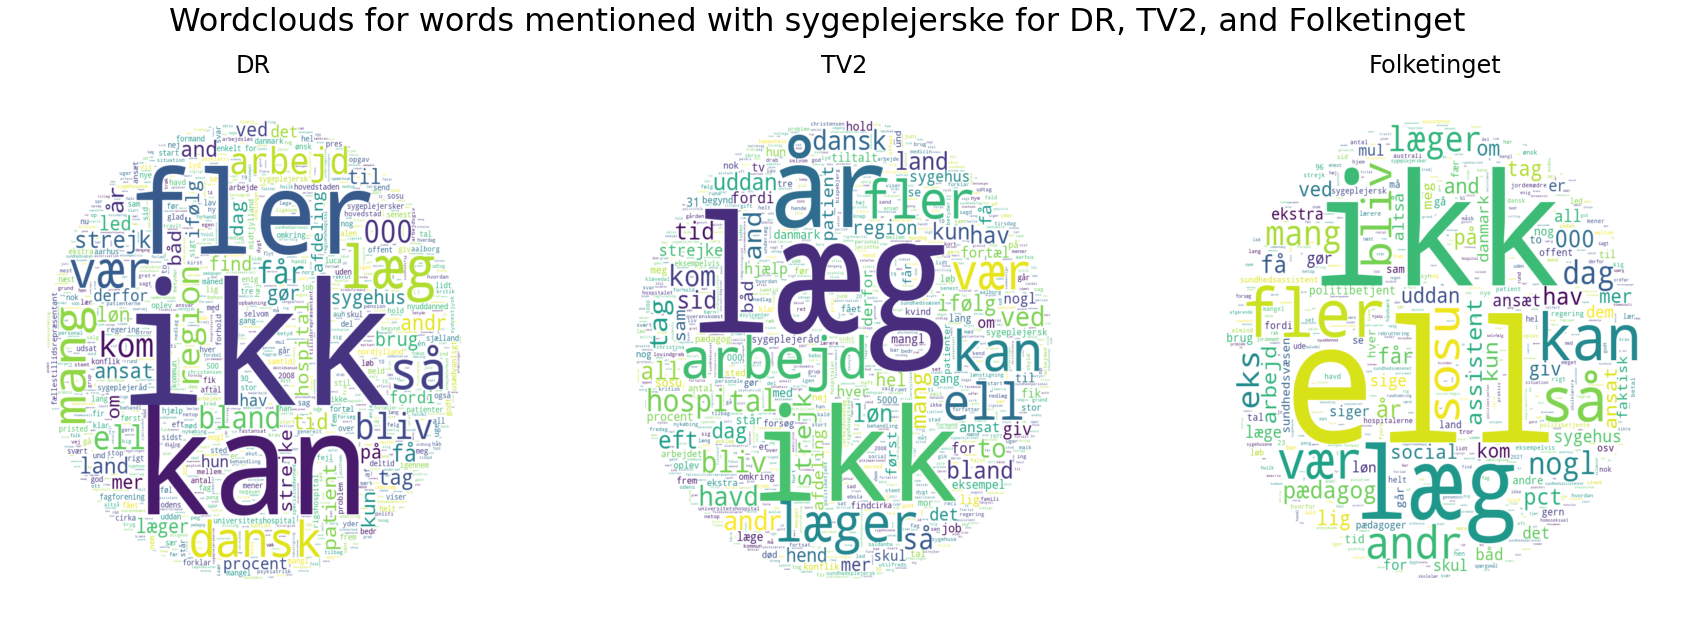

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(30,10))
_=fig.suptitle("Wordclouds for words mentioned with sygeplejerske for DR, TV2, and Folketinget", fontsize=32)
wc_dr = WordCloud(background_color="white", max_words=1000, mask=red_circle)
_=wc_dr.generate_from_frequencies(dr_bag_list)

_=plt.subplot(1, 3, 1)
ax =plt.imshow(wc_dr, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("DR", fontsize=24)
_=wc_tv2 = WordCloud(background_color="white", max_words=1000, mask=red_circle)
_=wc_tv2.generate_from_frequencies(tv2_bag_list)

_=plt.subplot(1, 3, 2)
ax =plt.imshow(wc_tv2, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("TV2", fontsize=24)
wc_ft = WordCloud(background_color="white", max_words=1000, mask=red_circle)
_=wc_ft.generate_from_frequencies(ft_bag_list)

_=plt.subplot(1, 3, 3)

ax =plt.imshow(wc_ft, interpolation="bilinear", aspect='auto')
_=plt.axis("off")
_=plt.title("Folketinget", fontsize=24)